<a href="https://colab.research.google.com/github/vicky30mar82/PyTorch/blob/main/CIFAR10_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torch torchvision

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [41]:
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck',)

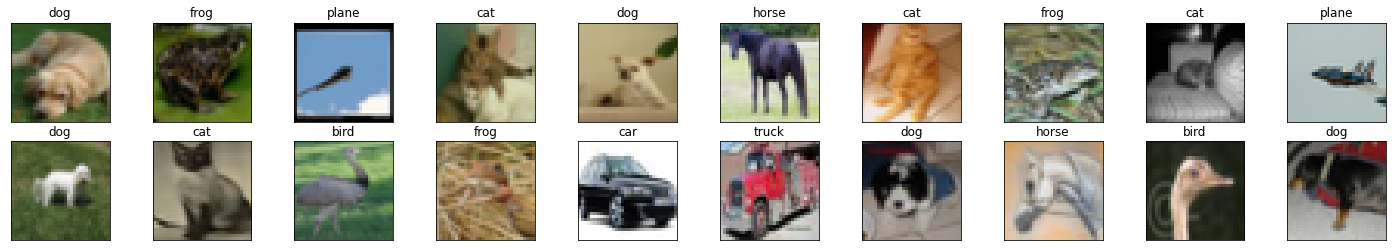

In [42]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [43]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(5*5*50, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 5*5*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [44]:
model = LeNet().cpu().to(device)
model

LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [46]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc.cpu())
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc.cpu())
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.8361, acc 33.3460 
validation loss: 1.6230, validation acc 41.2200 
epoch : 2
training loss: 1.5597, acc 43.1660 
validation loss: 1.4901, validation acc 46.0600 
epoch : 3
training loss: 1.4572, acc 47.3700 
validation loss: 1.4207, validation acc 48.8900 
epoch : 4
training loss: 1.3818, acc 50.2220 
validation loss: 1.3537, validation acc 51.1900 
epoch : 5
training loss: 1.3223, acc 52.6860 
validation loss: 1.2989, validation acc 53.6200 
epoch : 6
training loss: 1.2698, acc 54.5880 
validation loss: 1.2706, validation acc 54.4200 
epoch : 7
training loss: 1.2262, acc 56.4600 
validation loss: 1.2481, validation acc 54.8400 
epoch : 8
training loss: 1.1898, acc 57.7340 
validation loss: 1.1997, validation acc 57.1700 
epoch : 9
training loss: 1.1540, acc 59.3000 
validation loss: 1.1748, validation acc 58.1400 
epoch : 10
training loss: 1.1213, acc 60.1520 
validation loss: 1.1460, validation acc 58.7100 
epoch : 11
training loss: 1.0873, acc 61.4240 
va

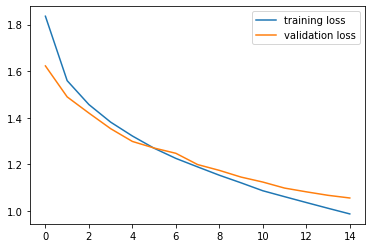

In [47]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

[tensor(33.3460), tensor(43.1660), tensor(47.3700), tensor(50.2220), tensor(52.6860), tensor(54.5880), tensor(56.4600), tensor(57.7340), tensor(59.3000), tensor(60.1520), tensor(61.4240), tensor(62.7660), tensor(63.2540), tensor(64.3720), tensor(65.2700)]
[tensor(41.2200), tensor(46.0600), tensor(48.8900), tensor(51.1900), tensor(53.6200), tensor(54.4200), tensor(54.8400), tensor(57.1700), tensor(58.1400), tensor(58.7100), tensor(60.2000), tensor(60.6600), tensor(61.8400), tensor(62.1900), tensor(62.2000)]


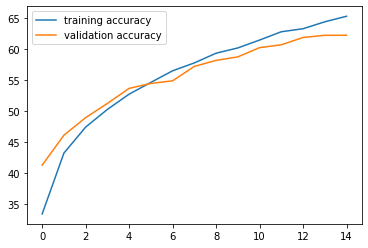

In [49]:
print(running_corrects_history)
print(val_running_corrects_history)
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [51]:
!pip3 install pillow = 4.0.0

ERROR: Invalid requirement: '='
Hint: = is not a valid operator. Did you mean == ?


In [59]:
import PIL.ImageOps

In [60]:
import requests 
from PIL import Image
url = 'https://upload.wikimedia.org/wikipedia/commons/5/55/Atelopus_zeteki1.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)


UnidentifiedImageError: ignored

In [ ]:
img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
img = img.view(img.shape[0], -1)
outputs = model(img)
_, preds = torch.max(outputs, 1)
print(preds.item())